In [1]:
import sys, getopt
import pandas as pd
import numpy as np
from datetime import datetime,timedelta, date
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from IPython.display import display as dsp
from IPython.display import clear_output
from IPython.display import Markdown
import ipywidgets as widgets
import matplotlib
%matplotlib inline

In [2]:
# Config

url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
days_range = (date.today() - date(2020,2,24)).days + 5
order = 4
log_scale = False

# Implementation

tick = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
data = pd.read_csv(url)
data.data = pd.to_datetime(data.data)
data['nuovi_decessi'] = data.deceduti.diff()
data['mortalita'] = data.deceduti / data.totale_casi
data['guariti'] = data.dimessi_guariti / data.totale_casi
data['ricoverati'] = data.totale_ospedalizzati / data.totale_casi
data['intensivi'] = data.terapia_intensiva / data.totale_casi
data_pct = data[data.columns.difference(['data','stato','note_it','note_en'])].pct_change()
data_pct.insert(0,'data', data.data)
updated_at = data.data.iloc[-1].strftime('%d/%m/%Y')


def thousands(value):
  return f'{value:,}'

def fmt_plot(aplot, size):
  global log_scale

  aplot.grid(which='major', color='#999999', linestyle='--')
  aplot.grid(which='minor', color='#CCCCCC', linestyle=':')
  aplot.set(xlabel="Giorni dal 24/02/2020")
  aplot.yaxis.set_major_formatter(tick)
  aplot.xaxis.set_major_locator(MultipleLocator(5))
  aplot.xaxis.set_minor_locator(AutoMinorLocator(5))
  if log_scale:
    return aplot
  aplot.yaxis.set_major_locator(MultipleLocator(size))
  aplot.yaxis.set_minor_locator(AutoMinorLocator(5))
  aplot.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
  aplot.axvline(x=26, color="red", label="lockdown completo", linestyle="--")

  return aplot

def format_row_wise(styler, formatter):
    for row, row_formatter in formatter.items():
        row_num = styler.index.get_loc(row)

        for col_num in range(len(styler.columns)):
            styler._display_funcs[(row_num, col_num)] = row_formatter
            
    return styler

def color_negative(val):    
    color = 'red' if val < 0 else 'black'
    weight = 'bold' if val < 0 else 'normal'
    return 'color: %s; font-weight:%s' % (color, weight)

styles = [
    dict(selector="*", props=[("font-size", "105%")])
]


# Dati Coronavirus Italia

In [3]:
# Data model:
#   'data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
#   'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
#   'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
#   'deceduti', 'totale_casi', 'tamponi', 'note_it', 'note_en'


statistics = data.loc[:,['data','totale_casi','nuovi_positivi','variazione_totale_positivi','deceduti',
                       'nuovi_decessi','terapia_intensiva','totale_ospedalizzati','dimessi_guariti',
                       'tamponi','casi_testati']] 

statistics.insert(0,'% mortalita', data.mortalita)
statistics.insert(0,'% intensivi', data.intensivi)
statistics.insert(0,'% ricoverati', data.ricoverati)
statistics.insert(0,'% guariti', data.guariti)

display(Markdown("### *Aggiornamento al " + updated_at + "*"))

recap = pd.DataFrame({    
    'Valore assoluto': [data.totale_casi.iloc[-1], data.nuovi_positivi.iloc[-1], 
                        data.variazione_totale_positivi.iloc[-1], data.deceduti.iloc[-1], 
                        data.nuovi_decessi.iloc[-1], data.terapia_intensiva.iloc[-1], 
                        data.totale_ospedalizzati.iloc[-1], data.dimessi_guariti.iloc[-1], 
                        data.tamponi.iloc[-1],data.casi_testati.iloc[-1], data.mortalita.iloc[-1], data.intensivi.iloc[-1], 
                        data.ricoverati.iloc[-1], data.guariti.iloc[-1]],
    'Variazione tot rispetto a ieri': [data.totale_casi.diff().iloc[-1], data.nuovi_positivi.diff().iloc[-1], 
                                     data.variazione_totale_positivi.diff().iloc[-1], data.deceduti.diff().iloc[-1], 
                                     data.nuovi_decessi.diff().iloc[-1], data.terapia_intensiva.diff().iloc[-1], 
                                     data.totale_ospedalizzati.diff().iloc[-1], data.dimessi_guariti.diff().iloc[-1], 
                                     data.tamponi.diff().iloc[-1],data.casi_testati.diff().iloc[-1], data.mortalita.diff().iloc[-1], 
                                     data.intensivi.diff().iloc[-1], data.ricoverati.diff().iloc[-1], 
                                     data.guariti.diff().iloc[-1]],
    'Variazione % rispetto a ieri': [data_pct.totale_casi.iloc[-1], data_pct.nuovi_positivi.iloc[-1], 
                                     data_pct.variazione_totale_positivi.iloc[-1], data_pct.deceduti.iloc[-1], 
                                     data_pct.nuovi_decessi.iloc[-1], data_pct.terapia_intensiva.iloc[-1], 
                                     data_pct.totale_ospedalizzati.iloc[-1], data_pct.dimessi_guariti.iloc[-1], 
                                     data_pct.tamponi.iloc[-1], data_pct.casi_testati.iloc[-1], data_pct.mortalita.iloc[-1], 
                                     data_pct.intensivi.iloc[-1], data_pct.ricoverati.iloc[-1], 
                                     data_pct.guariti.iloc[-1]]

}, index=['Totale casi', 'Totale nuovi casi', 'Variazione nuovi casi', 'Totale decessi',
             'Variazione decessi','Terapia intensiva','Ospedalizzati','Dimessi','Totale tamponi','Casi testati',
             'Mortalità', 'Critici', 'Ricoverati','Guariti'])

formatters = {
    'Mortalità': '{:+.2%}'.format,
    'Critici': '{:+.2%}'.format,
    'Ricoverati': '{:+.2%}'.format,
    'Guariti': '{:+.2%}'.format
}

recap_style = recap.style
recap_style.set_table_styles(styles)
recap_style.format('{:,.0f}'.format)
recap_style.format('{:+,.0f}'.format, subset=['Variazione tot rispetto a ieri'])
recap_style.format('{:+.2%}'.format, subset=['Variazione % rispetto a ieri'])
recap_style.applymap(color_negative)
styler = format_row_wise(recap_style, formatters)

display(recap_style)


### *Aggiornamento al 26/04/2020*

,Valore assoluto,Variazione tot rispetto a ieri,Variazione % rispetto a ieri
Totale casi,"197,675","+2,324",+1.19%
Totale nuovi casi,"2,324",-33,-1.40%
Variazione nuovi casi,256,+936,-137.65%
Totale decessi,"26,644",+260,+0.99%
Variazione decessi,260,-155,-37.35%
Terapia intensiva,"2,009",-93,-4.42%
Ospedalizzati,"23,381",-254,-1.07%
Dimessi,"64,928","+1,808",+2.86%
Totale tamponi,"1,757,659","+49,916",+2.92%
Casi testati,"1,210,639","+24,113",+2.03%


## Dati ultimi 5 giorni

In [4]:
pivot = pd.pivot_table(statistics, columns=['data'])          
pivot.sort_values(axis = 1, by=['data'], ascending=False, inplace=True)
pivot.columns = pivot.columns.strftime('%d/%m/%Y')

formatters = {
    '% mortalita': '{:,.2%}'.format,
    '% intensivi': '{:,.2%}'.format,
    '% ricoverati': '{:,.2%}'.format,
    '% guariti': '{:,.2%}'.format
}

pivot_style = pivot.iloc[:,0:5].style
pivot_style.set_table_styles(styles)
pivot_style.format('{:,.0f}'.format)
styler = format_row_wise(pivot_style, formatters)

display(styler)

,26/04/2020,25/04/2020,24/04/2020,23/04/2020,22/04/2020
% guariti,32.85%,32.31%,31.35%,30.31%,29.12%
% intensivi,1.02%,1.08%,1.13%,1.19%,1.27%
% mortalita,13.48%,13.51%,13.46%,13.45%,13.39%
% ricoverati,11.83%,12.10%,12.56%,13.23%,13.98%
casi_testati,"1,210,639","1,186,526","1,147,850","1,052,577","1,015,494"
deceduti,"26,644","26,384","25,969","25,549","25,085"
dimessi_guariti,"64,928","63,120","60,498","57,576","54,543"
nuovi_decessi,260,415,420,464,437
nuovi_positivi,"2,324","2,357","3,021","2,646","3,370"
tamponi,"1,757,659","1,707,743","1,642,356","1,579,909","1,513,251"


## Grafici andamenti 


In [45]:
plt.rcParams['figure.figsize'] = [16, 5]

#create tabs
out1 = widgets.Output()
out2 = widgets.Output()
tab_nest = widgets.Tab(children = [out1, out2])
tab_nest.set_title(0, 'Lineari')
tab_nest.set_title(1, 'Logaritmici')

def plot_func(columns):    
    global log_scale
    global data
    return data.loc[:,columns] \
            .plot(kind='line',
                subplots=True,
                sharex=True,
                layout=(1,3),
                grid=True,
                legend=True,
                logy=log_scale)

def draw_plots():    
    plt.rcParams['figure.figsize'] = [16, 5]    
    plots = plot_func(['totale_positivi','variazione_totale_positivi','terapia_intensiva'])
    plt_casi = fmt_plot(plots[0][0], 20000)
    plt_positivi = fmt_plot(plots[0][1], 1000)
    plt_intensivi = fmt_plot(plots[0][2], 1000)
    plt_casi.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
    plt_casi.axvline(x=26, color="red", label="lockdown completo", linestyle="--")
    handles, labels = plt_casi.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_casi.legend(by_label.values(), by_label.keys())

    plt_positivi.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
    plt_positivi.axvline(x=26, color="red", label="lockdown completo", linestyle="--")
    handles, labels = plt_positivi.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_positivi.legend(by_label.values(), by_label.keys())
    plt_intensivi.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
    plt_intensivi.axvline(x=26, color="red", label="lockdown completo", linestyle="--")
    handles, labels = plt_intensivi.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_intensivi.legend(by_label.values(), by_label.keys())
    
    plots = plot_func(['totale_ospedalizzati','deceduti','dimessi_guariti'])
    plt_ricoverati = fmt_plot(plots[0][0], 10000)
    plt_deceduti = fmt_plot(plots[0][1], 5000)
    plt_dimessi = fmt_plot(plots[0][2], 10000)
    plt_ricoverati.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
    plt_ricoverati.axvline(x=26, color="red", label="lockdown completo", linestyle="--")
    handles, labels = plt_ricoverati.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_ricoverati.legend(by_label.values(), by_label.keys())

    plt_deceduti.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
    plt_deceduti.axvline(x=26, color="red", label="lockdown completo", linestyle="--")
    handles, labels = plt_deceduti.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_deceduti.legend(by_label.values(), by_label.keys())

    plt_dimessi.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
    plt_dimessi.axvline(x=26, color="red", label="lockdown completo", linestyle="--")
    handles, labels = plt_dimessi.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_dimessi.legend(by_label.values(), by_label.keys())
    
    plots = plot_func(['nuovi_decessi','nuovi_positivi','tamponi'])
    plt_nuovi_decessi = fmt_plot(plots[0][0], 200)
    plt_nuovi = fmt_plot(plots[0][1], 1000)
    plt_tamponi = fmt_plot(plots[0][2], 200000)    
    plt_nuovi_decessi.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
    plt_nuovi_decessi.axvline(x=26, color="red", label="lockdown completo", linestyle="--")
    handles, labels = plt_nuovi_decessi.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_nuovi_decessi.legend(by_label.values(), by_label.keys())

    plt_nuovi.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
    plt_nuovi.axvline(x=26, color="red", label="lockdown completo", linestyle="--")
    handles, labels = plt_nuovi.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_nuovi.legend(by_label.values(), by_label.keys())

    plt_tamponi.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
    plt_tamponi.axvline(x=26, color="red", label="lockdown completo", linestyle="--")

    handles, labels = plt_tamponi.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_tamponi.legend(by_label.values(), by_label.keys())
    
    plots = plot_func(['ricoverati_con_sintomi','isolamento_domiciliare'])
    plt_sintomatici = fmt_plot(plots[0][0], 10000)
    plt_isolamento = fmt_plot(plots[0][1], 10000)
    plt_sintomatici.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
    plt_sintomatici.axvline(x=26, color="red", label="lockdown completo", linestyle="--")
    handles, labels = plt_sintomatici.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_sintomatici.legend(by_label.values(), by_label.keys())

    plt_isolamento.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
    plt_isolamento.axvline(x=26, color="red", label="lockdown completo", linestyle="--")
    handles, labels = plt_isolamento.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_isolamento.legend(by_label.values(), by_label.keys())        
    
    plt.show()
        
with out1:        
    draw_plots()
log_scale = True
with out2:
    draw_plots()
    
display(tab_nest)


# Variazioni percentuali giorno per giorno

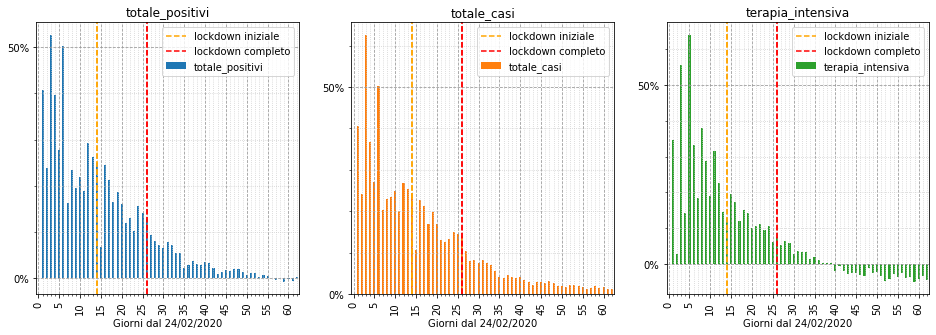

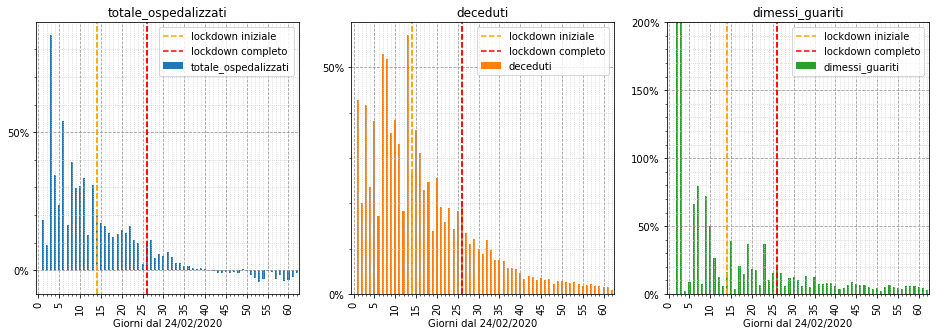

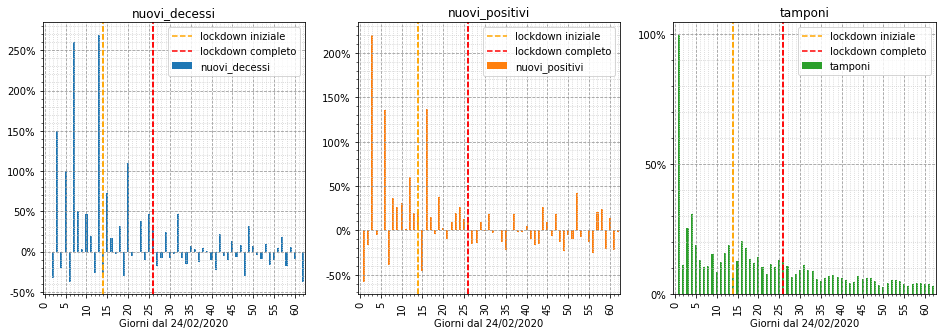

In [6]:
tick = matplotlib.ticker.FuncFormatter(lambda x, p: format(x, '.0%'))
xtick = matplotlib.ticker.FuncFormatter(lambda x, p: format(x, '.0f'))
plt.rcParams['figure.figsize'] = [16, 5]

def plot_func_pct(columns):
    global log_scale
    plot_pct = data_pct.loc[:,columns] \
        .plot(kind='bar',
              x='data',  
              subplots=True,
              sharex=True,
              layout=(1,3),
              grid=True,
              legend=False)
    plt_fmt = fmt_plot(plot_pct[0][0], .5)
    plt_fmt.yaxis.set_major_formatter(tick)
    plt_fmt.xaxis.set_major_formatter(xtick)
    plt_fmt.axvline(x=14, color="orange", label="lockdown iniziale", linestyle='--')
    plt_fmt.axvline(x=26, color="red", label="lockdown completo", linestyle='--')
    handles, labels = plt_fmt.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_fmt.legend(by_label.values(), by_label.keys())
    plt_fmt = fmt_plot(plot_pct[0][1], .5)
    plt_fmt.axvline(x=14, color="orange", label="lockdown iniziale", linestyle='--')
    plt_fmt.axvline(x=26, color="red", label="lockdown completo", linestyle='--')
    handles, labels = plt_fmt.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_fmt.legend(by_label.values(), by_label.keys())
    plt_fmt.yaxis.set_major_formatter(tick)
    plt_fmt.xaxis.set_major_formatter(xtick)
    plt_fmt = fmt_plot(plot_pct[0][2], .5)
    plt_fmt.axvline(x=14, color="orange", label="lockdown iniziale", linestyle='--')
    plt_fmt.axvline(x=26, color="red", label="lockdown completo", linestyle='--')
    handles, labels = plt_fmt.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt_fmt.legend(by_label.values(), by_label.keys())
    plt_fmt.yaxis.set_major_formatter(tick)
    plt_fmt.xaxis.set_major_formatter(xtick)    
    
    return plot_pct

plot_pct = plot_func_pct(['data','totale_positivi','totale_casi','terapia_intensiva'])
plot_pct = plot_func_pct(['data','totale_ospedalizzati','deceduti','dimessi_guariti'])
plot_pct[0][2].set_ylim([0,2])
plot_pct = plot_func_pct(['data','nuovi_decessi','nuovi_positivi','tamponi'])


In [7]:
x = data.index
# y = data.totale_casi
# def exponential_model(x,a,b,c):
#     return a * np.exp(-b * x) + c
# transformer = FunctionTransformer(np.log, validate=True)

# Exponential fit regression
# x_reshaped = x.values.reshape(-1,1)
# y_reshaped = y.values.reshape(-1,1)
# y_trans = transformer.fit_transform(y_reshaped)
pred_x = np.linspace(0, days_range, days_range)
# pred_x_reshape = pred_x.reshape(-1,1)
# model = LinearRegression().fit(x_reshaped, y_trans)     
# y_fit = model.predict(pred_x_reshape)


## Regressione polinomiale, grado = 4

BoundedIntText(value=67, description='Giorni predizione', min=63)

BoundedIntText(value=4, description='Grado polinomio', max=10, min=2)

Output()

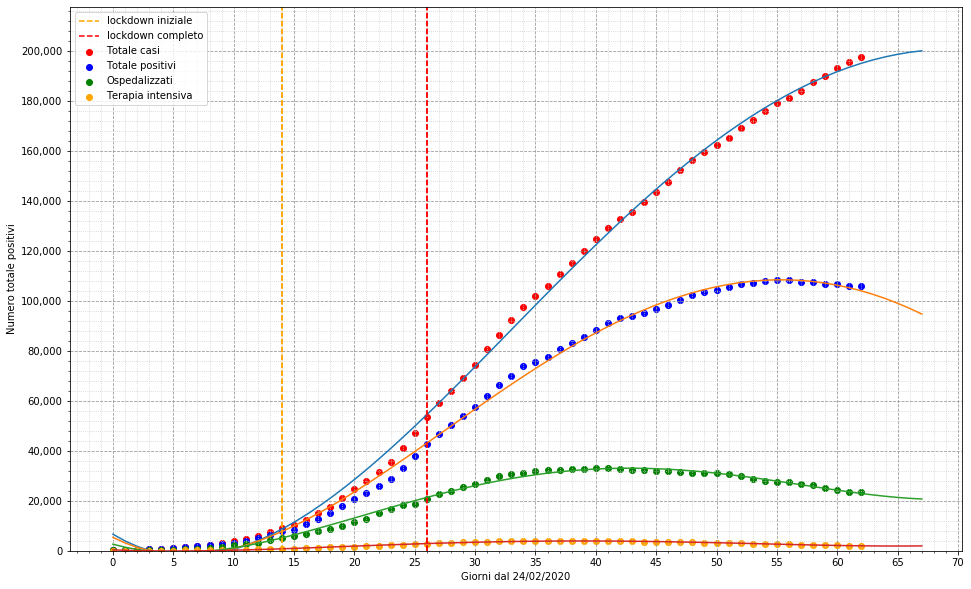

In [8]:
tick = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
plt.rcParams['figure.figsize'] = [16, 10]
# plt.semilogy()

# Regression analysis
def regression(order):
    global poly, poly1, poly2, poly3
    coefficients = np.polyfit(x.values, data.totale_casi.values, order)
    poly = np.poly1d(coefficients)
    coefficients1 = np.polyfit(x.values, data.totale_positivi.values, order)
    poly1 = np.poly1d(coefficients1)
    coefficients2 = np.polyfit(x.values, data.totale_ospedalizzati.values, order)
    poly2 = np.poly1d(coefficients2)
    coefficients3 = np.polyfit(x.values, data.terapia_intensiva.values, order)
    poly3 = np.poly1d(coefficients3)


output2 = widgets.Output()
def draw_predictions():
    clear_output()
    display(days_slider)
    display(order_slider)
    regression(order)
    fmt_plot(plt.gca(), 20000)
    plt.ylabel("Numero totale positivi")
    plt.ylim(1, 150000)
    pred_x = np.linspace(0, days_range, days_range)
    plt_scatter = plt.scatter(x,data.totale_casi,label="Totale casi", color="red")
    plt_scatter1 = plt.scatter(x,data.totale_positivi,label="Totale positivi", color="blue")
    plt_scatter2 = plt.scatter(x,data.totale_ospedalizzati, label="Ospedalizzati", color="green")
    plt_scatter3 = plt.scatter(x,data.terapia_intensiva, label="Terapia intensiva", color="orange")
    # plt_exp = plt.plot(pred_x, np.exp(y_fit), label="Regressione esponenziale")
    plt_poly = plt.plot(pred_x, poly(pred_x))
    plt_poly1 = plt.plot(pred_x, poly1(pred_x))
    plt_poly2 = plt.plot(pred_x, poly2(pred_x))
    plt_poly3 = plt.plot(pred_x, poly3(pred_x))
    plt.ylim(0,data.totale_casi.max().item() * 1.1)
    plt.axvline(x=14, color="orange", label="lockdown iniziale", linestyle="--")
    plt.axvline(x=26, color="red", label="lockdown completo", linestyle="--")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

days_slider = widgets.BoundedIntText(
    min = data.data.size,
    max = 100,
    step = 1,
    description = 'Giorni predizione',
    continuous_update = False,
    value = days_range
)

order_slider = widgets.BoundedIntText(
    min = 2,
    max = 10,
    step = 1,
    description = 'Grado polinomio',
    continuous_update = False,
    value = order
)

def days_handler(obj):
    global days_range
    if (obj.new != obj.old):    
        days_range = obj.new
        draw_predictions()        
days_slider.observe(days_handler,'value')

def order_handler(obj):
    global order
    if (obj.new != obj.old):    
        order = obj.new
        draw_predictions()        
order_slider.observe(order_handler,'value')

draw_predictions()
display(output2)


*fonte*: [Dati DPC](https://github.com/pcm-dpc/COVID-19/blob/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv)